# fitting a broadband spectrum of PKS1510-089 with sherpa

In [1]:
import sys
#sys.path.append("../../agnpy_js/")
sys.path.append("../../")
import numpy as np
import astropy.units as u
from astropy.coordinates import Distance
from astropy.table import Table
from agnpy.spectra import LogParabola, BrokenPowerLaw
from agnpy.synchrotron import Synchrotron
from agnpy.compton import SynchrotronSelfCompton, ExternalCompton
from sherpa.models import model
from sherpa import data
import matplotlib.pyplot as plt
from sherpa.fit import Fit
from sherpa.stats import Chi2
from sherpa.optmethods import LevMar
import pandas as pd

from agnpy.emission_regions import Blob
from agnpy.compton import ExternalCompton
from agnpy.targets import SSDisk, RingDustTorus
from astropy.constants import k_B, m_e,c, M_sun
mec2 = m_e.to("erg", equivalencies=u.mass_energy())

### sherpa wrapper of agnpy synchrotron

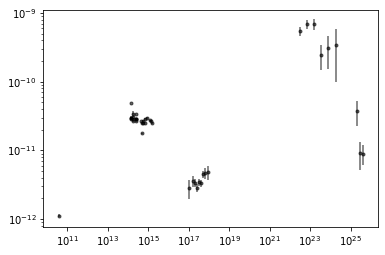

In [2]:
# read the PKS 1510-089 2015 "period B" spectrum
sed_table = pd.read_csv('../../agnpy/data/mwl_seds/pks1510_2015.txt', sep=r'\s+') #, header = None
evtoHz=u.eV.to("Hz", equivalencies=u.spectral())
tevtoerg= u.TeV.to("erg")

x = sed_table.iloc[:,0].values*evtoHz
y = sed_table.iloc[:,1].values *tevtoerg
y_err = sed_table.iloc[:,2].values*tevtoerg

plt.errorbar(x, y, yerr=y_err, ls="", marker=".", color="k", alpha=0.6)
plt.yscale("log")
plt.xscale("log")
plt.show()

In [3]:
# load them in a sherpa data object
sed = data.Data1D("sed", x, y, staterror=y_err)
print(sed)

name      = sed
x         = Float64[43]
y         = Float64[43]
staterror = Float64[43]
syserror  = None


In [4]:
#global parameters
T_dt=1.e3*u.K
z = 0.361
d_L = Distance(z=z).to("cm") 
#Gamma_jet=20
#delta_D=25
Gamma_jet=20
delta_D=20
alpha_jet=1/Gamma_jet # opening angle 
L_disk=6.7e45*u.Unit("erg s-1") # disk luminosity
xi_dt=0.6   # fraction of luminosity in DT
R_dt=6.47e18*u.cm  # radius of DT
r=6e17*u.cm # location of the emission region

beta = np.sqrt(1 - 1 / np.power(Gamma_jet, 2))
mu_s = (1 - 1 / (Gamma_jet * delta_D)) / beta # viewing angle

#R_b = 2.8e16 * u.cm # blob radius
#R_b = r*alpha_jet
#t_var = R_b/(delta_D*c)
#print ("t_var = ", t_var.to("day"))

In [5]:
class BrokenPowerLawDT_SSC(model.RegriddableModel1D):
    """wrapper"""
    def __init__(self, name="bpwl_ec"):
        # EED parameters
        self.log_k_e = model.Parameter(name, "log_k_e", -1., min=-5., max=1.)
        self.p1 = model.Parameter(name, "p1", 2.1, min=1.0, max=5.0)
        self.deltap1 = model.Parameter(name, "deltap1", 1., min=0.0, max=5.0)
        self.log_gamma_b = model.Parameter(name, "log_gamma_b", 3., min=1., max=6.) 
        self.log_gamma_min = model.Parameter(name, "log_gamma_min", 1., min=0., max=4.)
        self.log_gamma_max = model.Parameter(name, "log_gamma_max", 5., min=3., max=8.)
        
        # source general parameters 
        self.z = model.Parameter(name, "z", 0.1, min=0.01, max=1)
        self.d_L = model.Parameter(name, "d_L", 1e27, min=1e25, max=1e33)
        
        #emission region parameters 
        self.delta_D = model.Parameter(name, "delta_D", 10, min=1, max=50)        
        self.mu_s = model.Parameter(name, "mu_s", 0.9, min=0.0, max=1.0)
        self.log_B = model.Parameter(name, "log_B", 0., min=-3., max=1.)
        #self.log_R_b = model.Parameter(name, "log_R_b", 16., min=14., max=19.)
        self.alpha_jet = model.Parameter(name, "alpha_jet", 0.05, min=0.0, max=1.1)
        self.log_r = model.Parameter(name, "log_r", 17., min=16., max=20.)

        # DT parameters
        self.log_L_disk = model.Parameter(name, "log_L_disk", 45., min=42., max=48.)
        self.xi_dt = model.Parameter(name, "xi_dt", 0.6, min=0.0, max=1.0)
        self.T_dt = model.Parameter(name, "T_dt", 1.e3, min=1.e2, max=1.e4)
        self.R_dt = model.Parameter(name, "R_dt", 2.5e18, min=1.e17, max=1.e19)
        
        model.RegriddableModel1D.__init__(self, name,
                                          (self.log_k_e, self.p1, self.deltap1, 
                                           self.log_gamma_b, self.log_gamma_min, self.log_gamma_max, 
                                           self.z, self.d_L, 
                                           self.delta_D, self.mu_s, self.log_B, self.alpha_jet, self.log_r, 
                                           self.log_L_disk, self.xi_dt, self.T_dt, self.R_dt))
    def calc(self, pars, x):
        """Evaluate the model"""
        (log_k_e, p1, deltap1, log_gamma_b, log_gamma_min, log_gamma_max,z, d_L, 
         delta_D, mu_s, log_B, log_R_b,log_r,log_L_disk, xi_dt, T_dt, R_dt) = pars
        # add units
        k_e = 10**log_k_e*u.Unit("cm-3")
        gamma_b=10**log_gamma_b
        gamma_min=10**log_gamma_min
        gamma_max=10**log_gamma_max
        d_L *= u.cm
        B = 10**log_B*u.G
        #R_b = 10**log_R_b * u.cm
        x *= u.Hz
        p2=p1+deltap1
        L_disk=10**log_L_disk*u.Unit("erg s-1")
        R_dt*=u.cm
        T_dt*=u.K
        r=10**log_r*u.cm
        R_b=r*alpha_jet
        
        eps_dt = 2.7 * (k_B * T_dt / mec2).to_value("")
        sed_synch = Synchrotron.evaluate_sed_flux(
            x, z, d_L, delta_D, B, R_b, BrokenPowerLaw, k_e, p1, p2, gamma_b, gamma_min, gamma_max, ssa=True
        )
        sed_ssc = SynchrotronSelfCompton.evaluate_sed_flux(
            x, z, d_L, delta_D, B, R_b, BrokenPowerLaw, k_e, p1, p2, gamma_b, gamma_min, gamma_max
        )
        sed_dt = ExternalCompton.evaluate_sed_flux_dt(
            x, z, d_L, delta_D, mu_s, R_b, L_disk, xi_dt, eps_dt, R_dt, r, BrokenPowerLaw, k_e, p1, p2, gamma_b, gamma_min, gamma_max
        )
        return sed_synch + sed_ssc + sed_dt

In [6]:
# define the model
model = BrokenPowerLawDT_SSC()


gamma_min=10

# EED parameters
model.log_k_e=np.log10(0.1)
model.log_gamma_b = np.log10(150)
model.log_gamma_min = np.log10(gamma_min)
#model.log_gamma_min.freeze()
model.log_gamma_max = np.log10(4e4)


# source general parameters 
model.z = z
model.z.freeze()
model.d_L = d_L.cgs.value
model.d_L.freeze()

# emission region parameters
model.delta_D = delta_D
model.delta_D.freeze()
model.mu_s=mu_s
model.mu_s.freeze()

#model.log_R_b = np.log10(R_b.cgs.value)
#model.log_R_b.freeze()
model.alpha_jet=alpha_jet
model.alpha_jet.freeze()

model.log_L_disk=np.log10((L_disk.to("erg s-1")).value)
model.log_L_disk.freeze()
model.xi_dt=0.6
model.xi_dt.freeze()
model.T_dt=T_dt.to("K").value
model.T_dt.freeze()
model.R_dt=R_dt.to("cm").value
model.R_dt.freeze()

print(model)

bpwl_ec
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   bpwl_ec.log_k_e thawed           -1           -5            1           
   bpwl_ec.p1   thawed          2.1            1            5           
   bpwl_ec.deltap1 thawed            1            0            5           
   bpwl_ec.log_gamma_b thawed      2.17609            1            6           
   bpwl_ec.log_gamma_min thawed            1            0            4           
   bpwl_ec.log_gamma_max thawed      4.60206            3            8           
   bpwl_ec.z    frozen        0.361         0.01            1           
   bpwl_ec.d_L  frozen  6.12502e+27        1e+25        1e+33           
   bpwl_ec.delta_D frozen           20            1           50           
   bpwl_ec.mu_s frozen     0.998749            0            1           
   bpwl_ec.log_B thawed            0           -3            1           
   bpwl_

In [7]:
%%time
# fit!
fitter = Fit(sed, model, stat=Chi2(), method=LevMar())
min_x = 1e10
max_x = 1e27
sed.notice(min_x, max_x)
print(fitter)
res = fitter.fit()
print("\n** fit succesful?", res.succeeded)
print(res.format())

data      = sed
model     = bpwl_ec
stat      = Chi2
method    = LevMar
estmethod = Covariance

** fit succesful? True
Method                = levmar
Statistic             = chi2
Initial fit statistic = 1.63178e+06
Final fit statistic   = 7366.97 at function evaluation 977
Data points           = 43
Degrees of freedom    = 35
Probability [Q-value] = 0
Reduced statistic     = 210.485
Change in statistic   = 1.62441e+06
   bpwl_ec.log_k_e   -1.49648     +/- 0.448467    
   bpwl_ec.p1     1.43095      +/- 0.491174    
   bpwl_ec.deltap1   1.94456      +/- 0.489145    
   bpwl_ec.log_gamma_b   2.9548       +/- 0.134835    
   bpwl_ec.log_gamma_min   0.890948     +/- 0           
   bpwl_ec.log_gamma_max   4.62403      +/- 0           
   bpwl_ec.log_B   -0.45354     +/- 0.0225065   
   bpwl_ec.log_r   17.7439      +/- 0.0190161   
CPU times: user 1min 50s, sys: 8.95 s, total: 1min 59s
Wall time: 1min 59s


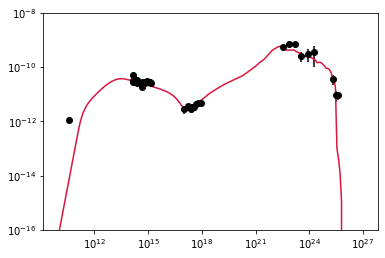

In [8]:
# plot the results
x = np.logspace(np.log10(min_x), np.log10(max_x), 200)
plt.errorbar(sed.x, sed.y, yerr=sed.staterror, marker="o", ls="", color="k")
plt.plot(x, model(x), ls="-", color="crimson")
plt.xscale("log")
plt.yscale("log")
plt.ylim(1e-16, 1e-8)
plt.show()

### draw individual components

In [9]:
pars2=dict(zip(res.parnames, res.parvals))
pars= { k.replace('bpwl_ec.', ''): v for k, v in pars2.items() }
print(pars)
k_e = 10**pars['log_k_e']*u.Unit("cm-3")
B = 10**pars['log_B']*u.G
p1=pars['p1']
p2=p1+pars['deltap1']
gamma_b = 10**pars['log_gamma_b']
gamma_max = 10**pars['log_gamma_max']
gamma_min = 10**pars['log_gamma_min']
r = 10**pars['log_r']*u.cm
R_b=r*alpha_jet

parameters = {
    "p1": p1,
    "p2": p2,
    "gamma_b": gamma_b,
    "gamma_min": gamma_min,
    "gamma_max": gamma_max,
}
spectrum_dict = {"type": "BrokenPowerLaw", "parameters": parameters}
blob = Blob(R_b, z, delta_D, Gamma_jet, B, k_e, spectrum_dict, spectrum_norm_type="differential")
blob.set_gamma_size(200)
print(blob)

dt = RingDustTorus(L_disk, xi_dt, T_dt, R_dt=R_dt)
print(dt)
nu1 = np.logspace(9, 30,100) * u.Hz
ec_dt = ExternalCompton(blob, dt, r)
# compute the SEDs
ec_dt_sed = ec_dt.sed_flux(nu1)
synch = Synchrotron(blob, ssa=True)
# let us compute synchrotron SED
synch_sed = synch.sed_flux(nu1) 
ssc = SynchrotronSelfCompton(blob, synch)
ssc_sed = ssc.sed_flux(nu1)

total=synch_sed
total+=ssc_sed
total+=ec_dt_sed

{'log_k_e': -1.4964756338100516, 'p1': 1.4309463142719197, 'deltap1': 1.9445573770504647, 'log_gamma_b': 2.9548036089006, 'log_gamma_min': 0.8909482191992849, 'log_gamma_max': 4.624029424511329, 'log_B': -0.45354040962719017, 'log_r': 17.74386420334784}
* spherical emission region
 - R_b (radius of the blob): 2.77e+16 cm
 - V_b (volume of the blob): 8.92e+49 cm3
 - z (source redshift): 0.36
 - d_L (source luminosity distance):6.13e+27 cm
 - delta_D (blob Doppler factor): 2.00e+01
 - Gamma (blob Lorentz factor): 2.00e+01
 - Beta (blob relativistic velocity): 9.99e-01
 - theta_s (jet viewing angle): 2.87e+00 deg
 - B (magnetic field tangled to the jet): 3.52e-01 G
* electron spectrum
 - broken power law
 - k_e: 3.19e-02 1 / cm3
 - p1: 1.43
 - p2: 3.38
 - gamma_b: 9.01e+02
 - gamma_min: 7.78e+00
 - gamma_max: 4.21e+04

* Ring Dust Torus:
 - L_disk (accretion disk luminosity): 6.70e+45 erg / s
 - xi_dt (fraction of the disk radiation reprocessed by the torus): 6.00e-01
 - T_dt (temperature

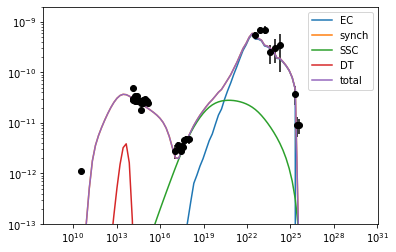

t_var =  0.5351428985305117 d


In [13]:
# showing of disk SED is still buggy
#disk = SSDisk(M_BH = 1.e9*M_sun, R_in=6, R_out=200, eta=1/12, L_disk=L_disk, R_g_units = True)
#disk_sed = disk.sed_flux(nu1, z)

dt_sed = dt.sed_flux(nu1, 1)
plt.errorbar(sed.x, sed.y, yerr=sed.staterror, marker="o", ls="", color="k")
plt.plot(nu1, ec_dt_sed, ls="-", label='EC')
plt.plot(nu1, synch_sed, ls="-", label='synch')
plt.plot(nu1, ssc_sed, ls="-", label='SSC')
#plt.plot(nu1, disk_sed, ls="-", label='disk')
plt.plot(nu1, dt_sed, ls="-", label='DT')
plt.plot(nu1, total, ls="-", label='total')

plt.xscale("log")
plt.yscale("log")
plt.ylim(1e-13, 2e-9)
plt.legend()
plt.show()

t_var = R_b/(delta_D*c)
print ("t_var = ", t_var.to("day"))